## Read data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('spotify-songs-preprocessed.csv')

df.head()

,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_rock,genre_r&b,genre_trap,genre_urban contemporary,genre_southern hip hop,genre_modern rock,genre_electro,genre_edm,genre_canadian pop,genre_house
0,71,0.853,0.606,0.0,66.0,1.0,0.0713,0.0561,0.000000,0.313,...,0,0,0,0,0,0,0,0,0,0
1,69,0.514,0.911,1.0,30.0,0.0,0.4100,0.0559,0.000000,0.775,...,0,1,0,1,0,0,0,0,0,0
2,88,0.780,0.768,6.0,63.0,0.0,0.2380,0.0371,0.000002,0.518,...,0,0,0,0,0,0,0,0,0,0
3,71,0.766,0.563,9.0,87.0,0.0,0.0339,0.0263,0.683000,0.115,...,0,0,0,0,0,0,0,0,0,0
4,75,0.754,0.811,5.0,56.0,1.0,0.0561,0.0185,0.000005,0.654,...,0,0,0,0,0,0,0,0,0,0


In [2]:
print ("Records and variables: ", df.shape)

Records and variables:  (2199, 30)


## Split data into train and test set

In [3]:
from sklearn.model_selection import train_test_split

y = df.pop('popular') # Target column
x = df

#split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=100,
    stratify=y
)

In [4]:
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  (1649, 29) (1649,)
Test:  (550, 29) (550,)


## Train the model

In [37]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary:logistic',  
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'colsample_bytree': 0.3,
    'eval_metric': 'auc'  
}

xg_clf = xgb.XGBClassifier(**params)

In [38]:
xg_clf.fit(x_train, y_train)
preds = xg_clf.predict(x_test)
preds2 = xg_clf.predict(x_train)

In [90]:
acc1 = accuracy_score(y_test, preds)
acc2 = accuracy_score(y_train, preds2)

print("Attempt 1 Train accuracy: %f" % (acc2))
print("Attmept 1 Test accuracy: %f" % (acc1))

Attempt 1 Train accuracy: 0.788963
Attmept 1 Test accuracy: 0.763636


In [40]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Some inputs do not have OOB scores",
    category=UserWarning,
    module="sklearn.ensemble._forest"
)

In [41]:
data_dmatrix = xgb.DMatrix(data=x, label=y)

In [44]:
cv_results = xgb.cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics='auc',     
    as_pandas=True,
    seed=123
)

# and review results (latest iterations)
cv_results.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
45,0.841251,0.003717,0.751640,0.018685
46,0.842386,0.003757,0.751443,0.018609
47,0.843998,0.003684,0.751461,0.018846
48,0.845171,0.003434,0.751376,0.018658
49,0.845501,0.003754,0.752301,0.018693


In [107]:
# 86.78

gbm_param_grid = {'objective': ['binary:logistic'],
                  'learning_rate': [0.2, 0.1, 0.3, 1], 
                  'n_estimators': [50,5,10],
                  'max_depth': [5,10,15],
                  'colsample_bytree': [0.7, 0.5, 1],
                  'subsample':[0.6,0.7,0.65]} # subsample is % of rows per tree

In [108]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
gbm = xgb.XGBClassifier()
grid_roc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1)

grid_roc.fit(x, y)

print ("Completed in %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Completed in 73.5926148891449 seconds


In [109]:
grid_roc.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 10,
 'objective': 'binary:logistic',
 'subsample': 0.65}

In [110]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
grid_roc.best_score_

0.7340722025181653

In [111]:
train_acc = round(grid_roc.score(x_train, y_train) * 100,2) #Train Accuracy score
test_acc = round(grid_roc.score(x_test, y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  85.29 %
Test Accuracy score:  86.78 %


## Final Model performance

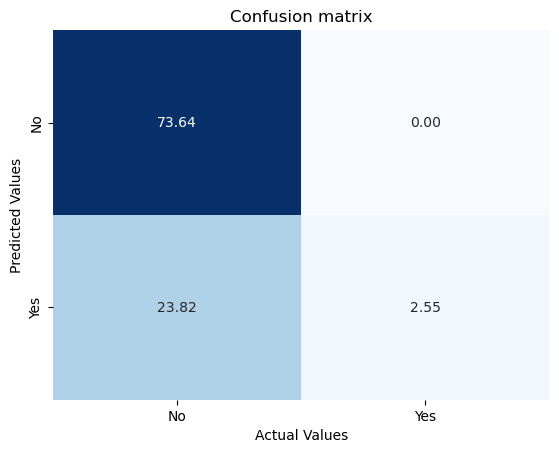

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cutoff = 0.5

model = grid_roc

prob_pred = model.predict_proba(x_test)[:, 1]
predictions_test = (prob_pred >= cutoff).astype(int)

test_conf_matrix = confusion_matrix(y_test, predictions_test)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2) 
labels = ['No', 'Yes']

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in test_conf_matrix_percentage.flatten()]

# Draw heatmap using confusion matrix
import seaborn as sns
sns.heatmap(test_conf_matrix_percentage, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');

Optimal Threshold: 0.29


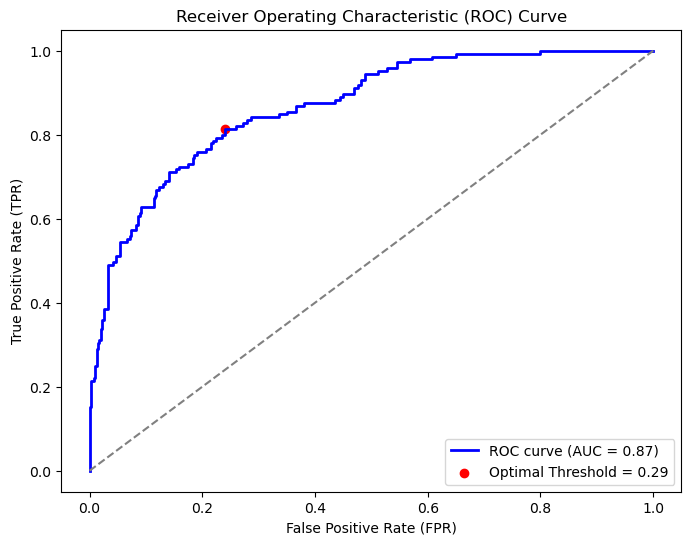

In [118]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)  
optimal_idx = np.argmax(tpr - fpr)  # Best trade-off between TPR and FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classification

# Highlight optimal threshold 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()